In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft


sns.set()

In [2]:
df = pd.read_csv('dataset/Rainfall_Data_LL.csv')
df.head()

,Name,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,...,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,June-September,Oct-Dec,Latitude,Longitude
0,ROW1,Andaman & Nicobar Islands,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,...,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3,12.61124,92.83165
1,ROW2,Andaman & Nicobar Islands,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,...,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7,12.61124,92.83165
2,ROW3,Andaman & Nicobar Islands,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,...,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6,12.61124,92.83165
3,ROW4,Andaman & Nicobar Islands,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,...,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0,12.61124,92.83165
4,ROW5,Andaman & Nicobar Islands,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,...,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8,12.61124,92.83165


In [3]:
subdivs = np.unique(df['SUBDIVISION'].values)

In [4]:
time_data = []
for year in range(1901, 2018):
    for month in range(1, 13):
        time_data.append(date(year, month, 1))


def get_state_data(state: str, df: pd.DataFrame):
    df_state = df[df['SUBDIVISION']==state]
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
              'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    rainfall_data = []
    for i, val in df_state.iterrows():
        for month in months:
            rainfall_data.append(val[month])
    return np.array(rainfall_data)

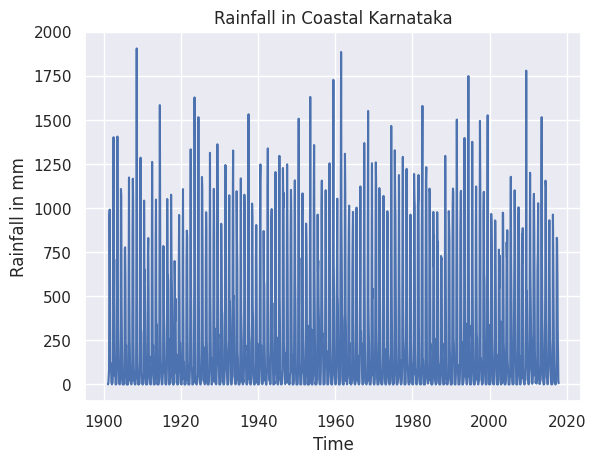

In [5]:
state = 'Coastal Karnataka'
data = get_state_data(state, df)

plt.plot(time_data, data)
plt.title(f'Rainfall in {state}')
plt.ylabel('Rainfall in mm')
plt.xlabel('Time')
plt.show()

In [6]:
mnths_to_plot = 72

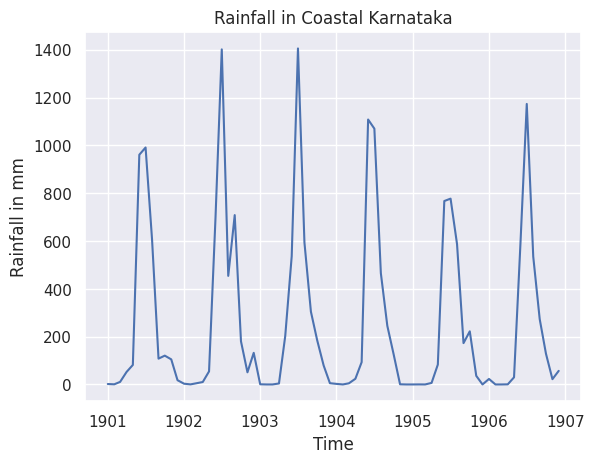

In [7]:
plt.plot(time_data[:mnths_to_plot], data[:mnths_to_plot])
plt.title(f'Rainfall in {state}')
plt.ylabel('Rainfall in mm')
plt.xlabel('Time')
plt.show()

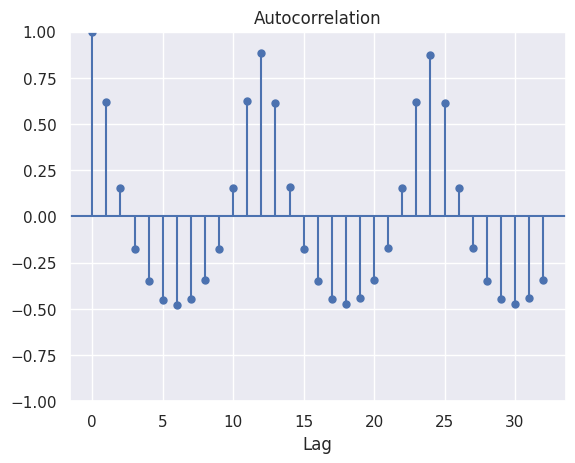

In [8]:
plot_acf(data, alpha=None)
plt.xlabel('Lag')
plt.show()

In [9]:
decompose = seasonal_decompose(data, model='additive', period=12)

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid


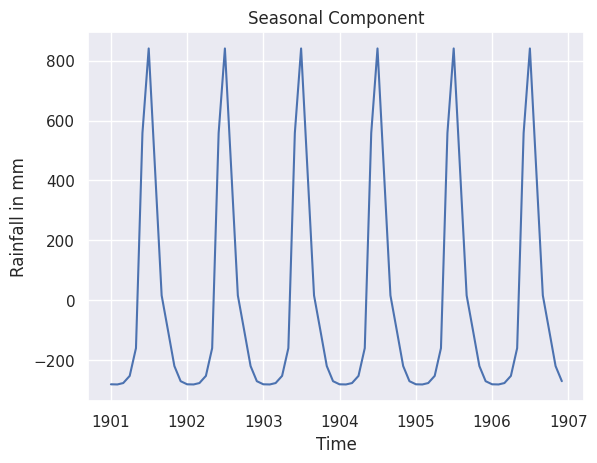

In [10]:
plt.plot(time_data[:mnths_to_plot], seasonal[:mnths_to_plot])
plt.title(f'Seasonal Component')
plt.ylabel('Rainfall in mm')
plt.xlabel('Time')
plt.show()


In [29]:
mnths_to_plot = -1

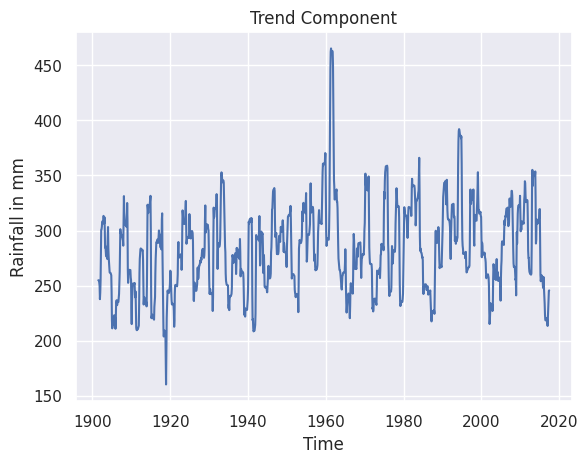

In [30]:
plt.plot(time_data[:mnths_to_plot], trend[:mnths_to_plot])
plt.title(f'Trend Component')
plt.ylabel('Rainfall in mm')
plt.xlabel('Time')
plt.show()


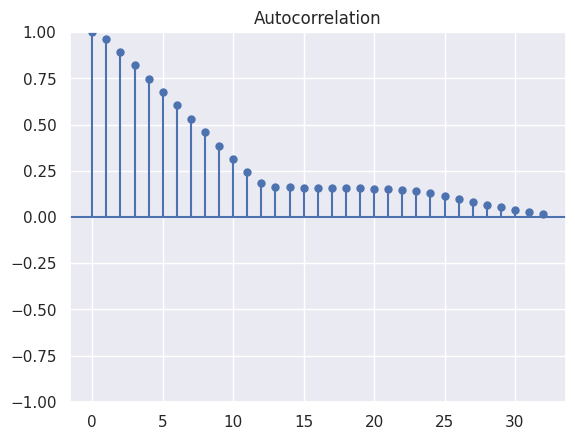

In [39]:
plot_acf(trend[6:-6], alpha=None)
plt.show()

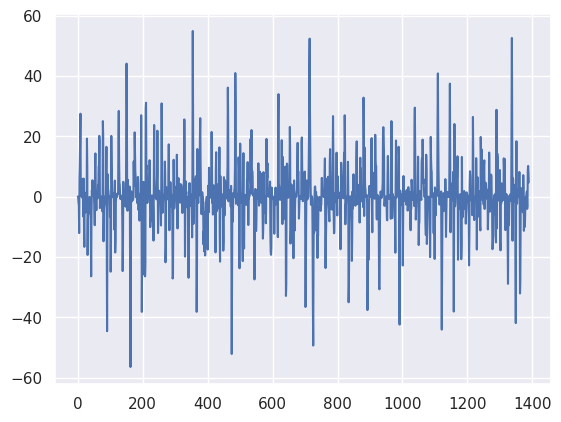

In [42]:

del1 = trend[6:-6][1:] - trend[6:-6][:-1]
plt.plot(del1[:mnths_to_plot])
plt.show()


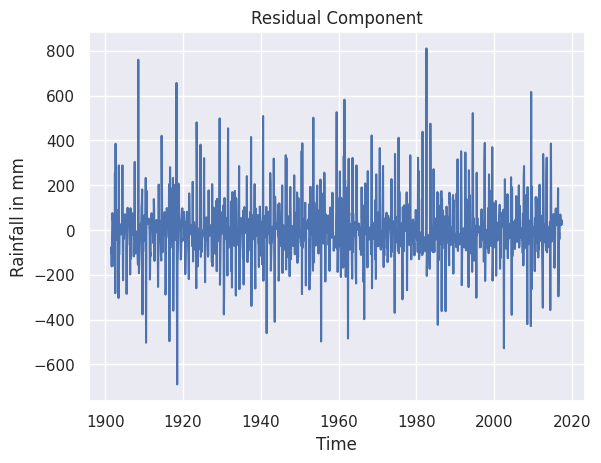

In [31]:
plt.plot(time_data[:mnths_to_plot], residual[:mnths_to_plot])
plt.title(f'Residual Component')
plt.ylabel('Rainfall in mm')
plt.xlabel('Time')
plt.show()


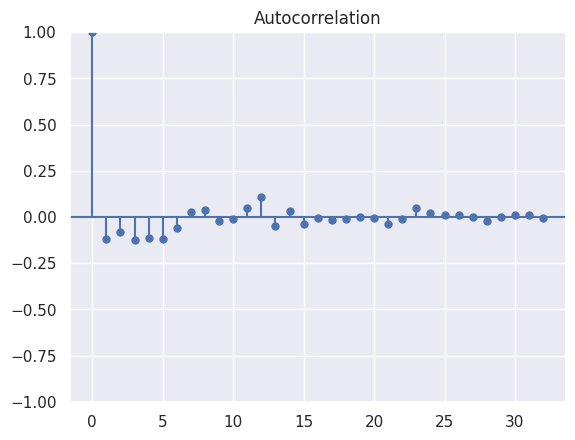

In [33]:
plot_acf(residual[6:-6], alpha=None)
plt.show()

---

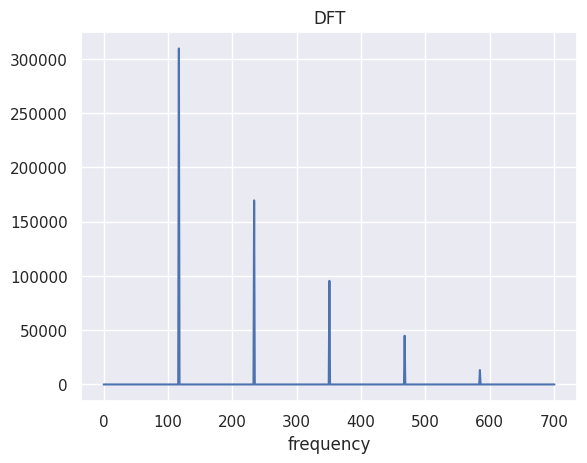

In [61]:
dft = np.abs(fft(seasonal))
plt.plot(dft[:702])
plt.title('DFT')
plt.xlabel('frequency')
plt.show()


In [13]:
np.where(dft[:702]>100)

(array([117, 234, 351, 468, 585]),)

---

# Parametric

$$
\begin{align}
x_t &= m_t + s_t + y_t\\
where\\
m_t &= a_0 + a_1 t\\
s_t &= \sum_{k=1}^{5} a_k \sin\left(\frac{2\pi kt}{12}\right)+b_k \cos\left(\frac{2\pi kt}{12}\right)\\
\end{align}
$$

In [26]:
size = data.size
period = 12
time = np.arange(1, size+1)
num_coff_seasonal = 5

A = np.c_[
    np.ones(size),
    np.arange(size)+1,   
]

Sines = np.c_[
    [np.sin(2*np.pi*k*time/period) for k in range(1, num_coff_seasonal+1)]
    ].T

Cosines = np.c_[
    [np.cos(2*np.pi*k*time/period) for k in range(1, num_coff_seasonal+1)]
    ].T

A = np.c_[A, Sines, Cosines]
A.shape

(1404, 12)

In [27]:
coeffs = np.linalg.inv(A.T@A)@A.T@data
coeffs

array([ 2.67691589e+02,  2.17231360e-02, -2.61504546e+02,  2.07319002e+02,
       -1.27736485e+02,  6.34944711e+01, -1.26137781e+01, -3.54840315e+02,
        1.23398247e+02, -4.56248570e+01,  7.08323572e+00, -1.44867496e+01])

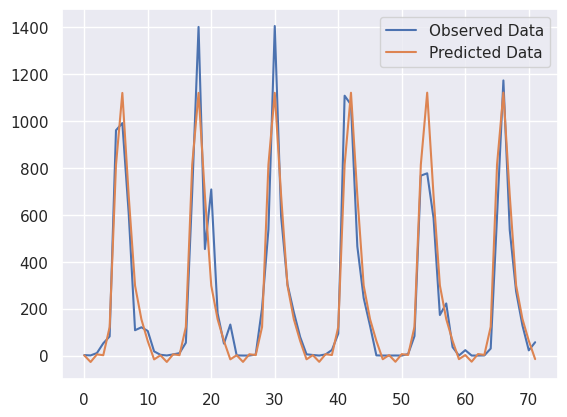

Error: 5180.913941667764


In [28]:

pred = A@coeffs

plt.plot(data[:mnths_to_plot], label='Observed Data')
plt.plot(pred[:mnths_to_plot], label='Predicted Data')
plt.legend()
plt.show()

print(f'Error: {np.linalg.norm(pred-data)}')

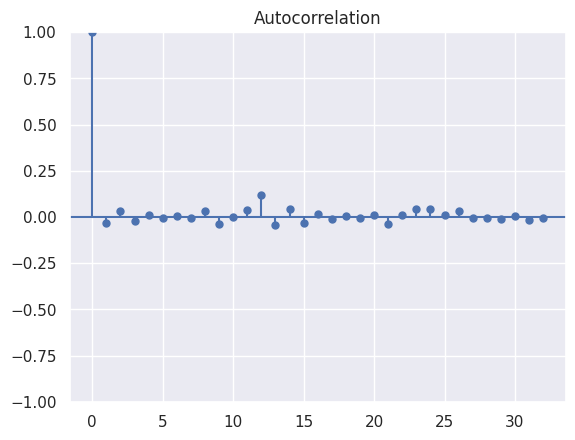

In [62]:
residual_p = data-pred
plot_acf(residual_p, alpha=None)
plt.show()